In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import cvxpy as cp
import warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from IPython.display import Image
warnings.filterwarnings("ignore", category=UserWarning)

## Data: Subregion Output Emission Rate (eGrid 2023)

In [2]:
# Properly read CSV with correct header row
subregions_rates_only = pd.read_csv("subregion_output_emit_rates.csv", skiprows = 2, header=1)
subregions_rates_only
# Drop any fully empty rows (e.g., bottom row with NaNs)
subregions_rates_only.dropna(how='all', inplace=True)

# Define the columns to retain
co2_columns_to_keep = [
    'eGRID subregion acronym',
    'eGRID subregion name',
    'CO₂',           # total output emission rate (lb/MWh)
    'CO₂.1',         # non-baseload output emission rate (lb/MWh)
    'Grid Gross Loss (%)'
]

# Separate U.S. aggregate row
us_CO2_only = subregions_rates_only[subregions_rates_only['eGRID subregion acronym'] == 'U.S.'][co2_columns_to_keep]

# Subregion-level data (excluding national aggregate)
subregions_CO2_only = subregions_rates_only[subregions_rates_only['eGRID subregion acronym'] != 'U.S.'][co2_columns_to_keep][:-1]

In [3]:
subregions_CO2_only

,eGRID subregion acronym,eGRID subregion name,CO₂,CO₂.1,Grid Gross Loss (%)
0,AKGD,ASCC Alaska Grid,899.00,1077.11,0.041
1,AKMS,ASCC Miscellaneous,519.45,1548.61,0.041
2,AZNM,WECC Southwest,740.81,1260.44,0.041
3,CAMX,WECC California,436.66,1033.99,0.041
4,ERCT,ERCOT All,738.04,1264.94,0.042
5,FRCC,FRCC All,801.89,1033.95,0.042
6,HIMS,HICC Miscellaneous,1122.12,1596.39,0.044
7,HIOA,HICC Oahu,1489.36,1753.44,0.044
8,MROE,MRO East,1402.01,1713.77,0.042
9,MROW,MRO West,920.02,1776.58,0.042


## National Average Emission Rate - $\text{CO}_2$ only

In [4]:
us_CO2_only.drop(columns=["eGRID subregion name"])

,eGRID subregion acronym,CO₂,CO₂.1,Grid Gross Loss (%)
27,U.S.,771.52,1393.7,0.042


### Note:

To simplify analysis and focus on the most impactful greenhouse gas, we filtered the original eGRID 2023 emission dataset to retain only carbon dioxide (CO₂)-related variables. CO₂ accounts for approximately 80% of total U.S. greenhouse gas emissions, making it the most relevant variable for assessing emissions intensity.

The source dataset includes greenhouse gas emissions for the year 2023, reported across 27 eGRID subregions in the United States. Each row corresponds to a subregion, and columns include total output and non-baseload output emission rates for CO₂, CH₄, N₂O, and CO₂e, along with NOₓ, SO₂, and grid gross loss percentages. The final row contains aggregate national values, representing the overall emissions performance of the U.S. electricity grid.

CO₂ is the dominant greenhouse gas from electricity generation.

Dropping CH₄, N₂O, and other trace gases: Reduces complexity, avoids multicollinearity in models, enables focused emissions benchmarking. This decision aligns with EPA-reported breakdown where CO₂ = ~80% of U.S. emissions.

$\textbf{Data Formatting Note:}$

Before visualizing or modeling, we needed to convert all emission values to float type. Although this seems like a minor preprocessing step, the dataset originally included many numbers formatted as strings (due to commas or Excel formatting), which caused errors during plotting and numeric operations. Careful cleaning ensured accurate type conversion and enabled seamless analysis going forward.

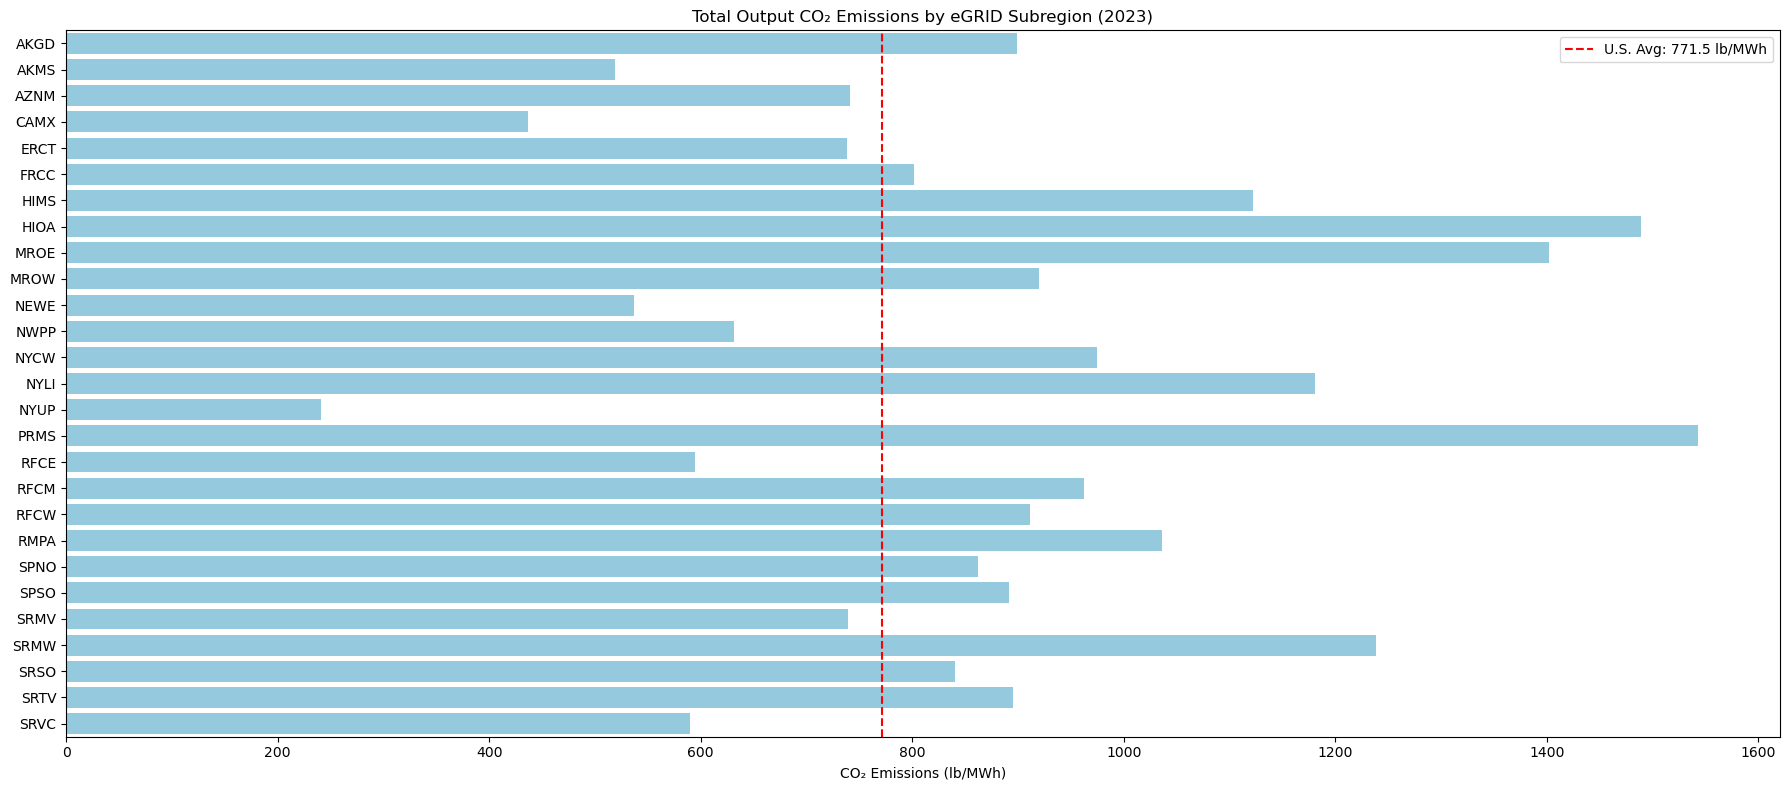

In [5]:
# Ensure CO₂ column is float (if not already done)
subregions_CO2_only = subregions_CO2_only.copy() 
subregions_CO2_only["CO₂"] = (
    subregions_CO2_only["CO₂"]
    .astype(str)
    .str.replace(",", "")
    .astype(float)
)

# Extract national average from separate table
national_avg = float(us_CO2_only["CO₂"].values[0]) 

# Plot
plt.figure(figsize=(18, 8))
sns.barplot(
    y="eGRID subregion acronym",
    x="CO₂",
    data=subregions_CO2_only,
    color="skyblue"
)

# Add horizontal line for U.S. average
plt.axvline(national_avg, color="red", linestyle="--", label=f"U.S. Avg: {national_avg:.1f} lb/MWh")

# Add labels and title
plt.xlabel("CO₂ Emissions (lb/MWh)")
plt.ylabel("")
plt.title("Total Output CO₂ Emissions by eGRID Subregion (2023)")
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
def count_regions_above_average(df, co2_column="CO₂", average=771.5):
    return (df[co2_column] > average).sum()

num_above_avg = count_regions_above_average(subregions_CO2_only)
print(f"{num_above_avg} subregions are above the national average of 771.5 lb/MWh.")

17 subregions are above the national average of 771.5 lb/MWh.


In [7]:
# Total number of subregions
total_subregions = len(subregions_CO2_only)

# Number of subregions above average
num_above_avg = count_regions_above_average(subregions_CO2_only)

# Percentage above average
percent_above_avg = (num_above_avg / total_subregions) * 100

print(f"{percent_above_avg:.1f}% of subregions are above the national average of 771.5 lb/MWh.")

63.0% of subregions are above the national average of 771.5 lb/MWh.


## Subregion Resource Mix (eGrid)

In [8]:
sub_resource_mix = pd.read_csv("subregion_resource_mix.csv", skiprows=2)
sub_resource_mix_cleaned = sub_resource_mix.iloc[:-2]

# Keep only subregion-level data
subregions_mix_only = sub_resource_mix_cleaned[sub_resource_mix_cleaned['eGRID subregion acronym'] != 'U.S.']
subregions_mix_only

,eGRID subregion acronym,eGRID subregion name,Nameplate Capacity (MW),Net Generation (MWh),Coal,Oil,Gas,Other Fossil,Nuclear,Hydro,Biomass,Wind,Solar,Geo- thermal,Other unknown/ purchased fuel
0,AKGD,ASCC Alaska Grid,2194.0,5.100447e+06,0.143,0.090,0.604,0.000,0.000,0.139,0.008,0.016,0.000,0.000,0.000
1,AKMS,ASCC Miscellaneous,901.5,1.585195e+06,0.000,0.247,0.065,0.000,0.000,0.671,0.000,0.018,0.000,0.000,0.000
2,AZNM,WECC Southwest,54243.2,1.667284e+08,0.117,0.000,0.459,0.000,0.189,0.028,0.003,0.081,0.086,0.037,0.000
3,CAMX,WECC California,99264.3,2.168418e+08,0.021,0.000,0.411,0.007,0.082,0.147,0.022,0.067,0.205,0.037,0.001
4,ERCT,ERCOT All,145507.7,4.744374e+08,0.127,0.000,0.493,0.004,0.086,0.001,0.002,0.227,0.059,0.000,0.001
5,FRCC,FRCC All,72773.8,2.440250e+08,0.047,0.005,0.749,0.006,0.123,0.001,0.011,0.000,0.055,0.000,0.004
6,HIMS,HICC Miscellaneous,1099.2,2.614533e+06,0.000,0.659,0.000,0.000,0.000,0.036,0.047,0.121,0.064,0.074,0.000
7,HIOA,HICC Oahu,2352.0,6.547823e+06,0.000,0.830,0.000,0.027,0.000,0.000,0.025,0.043,0.074,0.000,0.000
8,MROE,MRO East,9637.9,2.443890e+07,0.396,0.003,0.427,0.000,0.000,0.043,0.030,0.054,0.047,0.000,0.000
9,MROW,MRO West,77431.6,2.409629e+08,0.352,0.001,0.131,0.002,0.078,0.041,0.007,0.376,0.012,0.000,0.001


### Resource Mix - National 

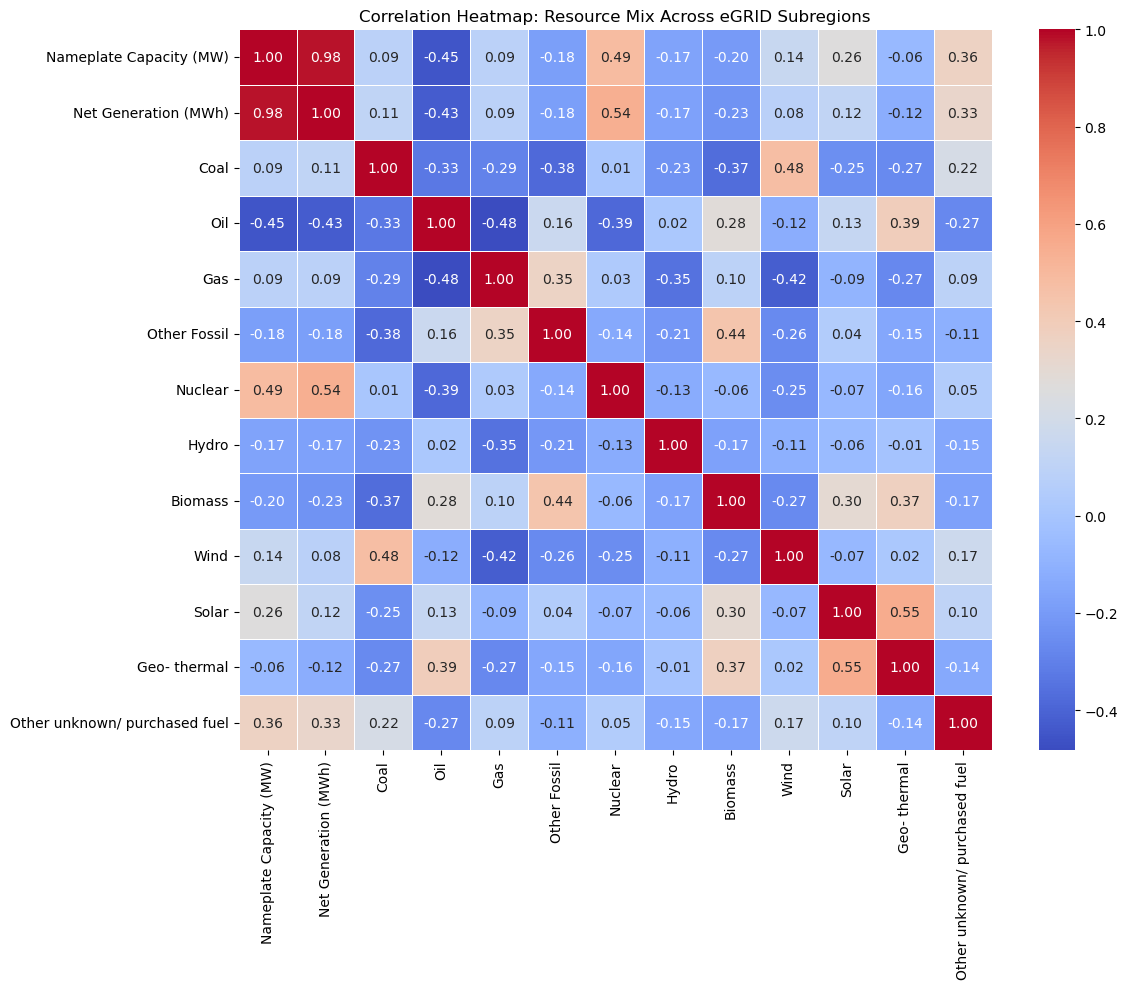

In [9]:
# Drop non-numeric or irrelevant columns for correlation
numeric_cols = subregions_mix_only.drop(columns=["eGRID subregion acronym", "eGRID subregion name"]).copy()

# Compute correlation matrix
corr_matrix = numeric_cols.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap: Resource Mix Across eGRID Subregions")
plt.tight_layout()
plt.show()

### Interpretation

The correlation heatmap reveals several important relationships between electricity generation resources and capacity across eGRID subregions. First, there is a very strong positive correlation (+0.98) between net generation and nameplate capacity, which is expected—regions with higher installed capacity typically produce more electricity. Resource-specific trends show that coal and oil are moderately negatively correlated (–0.48), implying that subregions relying on one tend to avoid the other. In contrast, solar and wind show a moderate positive correlation (+0.55), suggesting that investments in one are often accompanied by investments in the other. A similar pattern is seen between other fossil sources and biomass (+0.44), which may reflect regional strategies that combine alternative combustion fuels.

Further, coal is negatively correlated with several renewable sources, including solar (–0.42), wind (–0.42), and biomass (–0.37), indicating that coal-dominant subregions tend to be less invested in renewables. Lastly, some resource pairs exhibit little to no correlation—for example, gas and solar (–0.07) or hydro and oil (0.02)—which suggests independent usage patterns or differing regional policies. Overall, the heatmap reveals coherent patterns in regional energy strategies while also highlighting trade-offs between fossil and renewable sources.

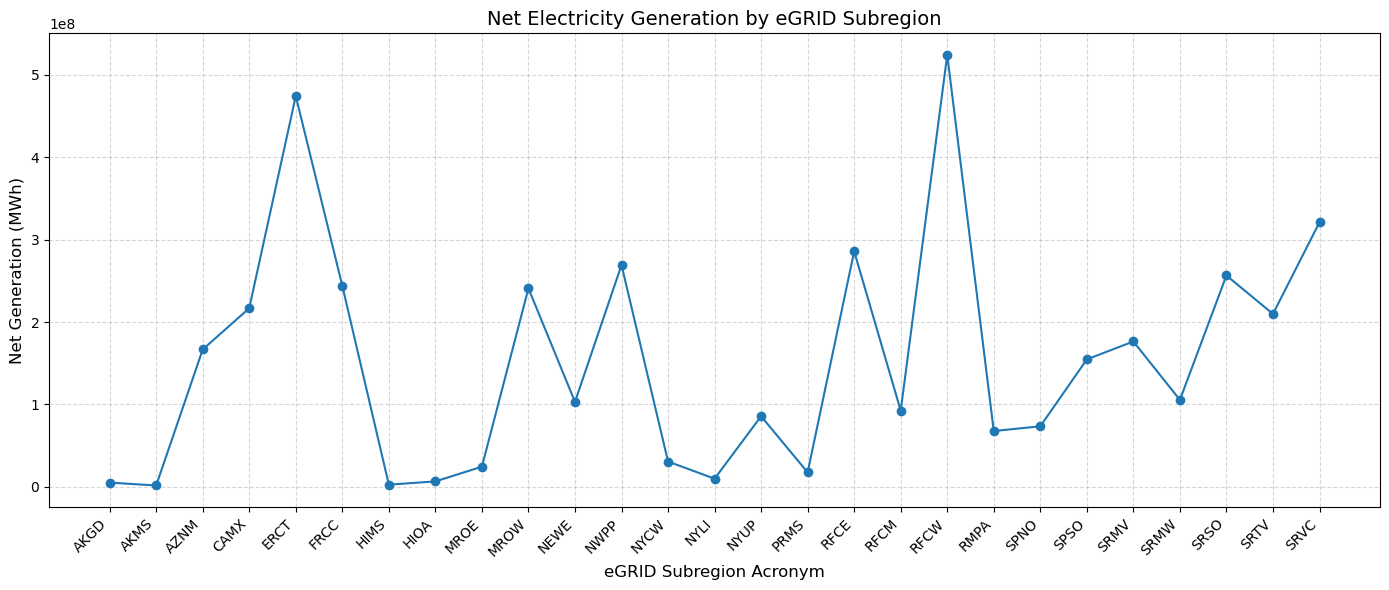

In [55]:
subregions_mix_only = subregions_mix_only.reset_index()
subregions_indexed = subregions_mix_only.set_index('eGRID subregion acronym')

# Plot
plt.figure(figsize=(14, 6))
plt.plot(subregions_indexed.index, 
         subregions_indexed["Net Generation (MWh)"], 
         marker='o')

plt.title("Net Electricity Generation by eGRID Subregion", fontsize=14)
plt.xlabel("eGRID Subregion Acronym", fontsize=12)
plt.ylabel("Net Generation (MWh)", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Analysis

The vertical axis shows net generation in megawatt-hours (MWh), and the horizontal axis lists subregions in order. There is substantial variation in generation levels, with certain subregions—such as RFCW and ERCT—showing the highest levels of generation, surpassing 400 million MWh. Others, like AKMS and HIOA, generate significantly less, remaining under 10 million MWh. These differences reflect regional disparities in population, infrastructure, and energy demand. 

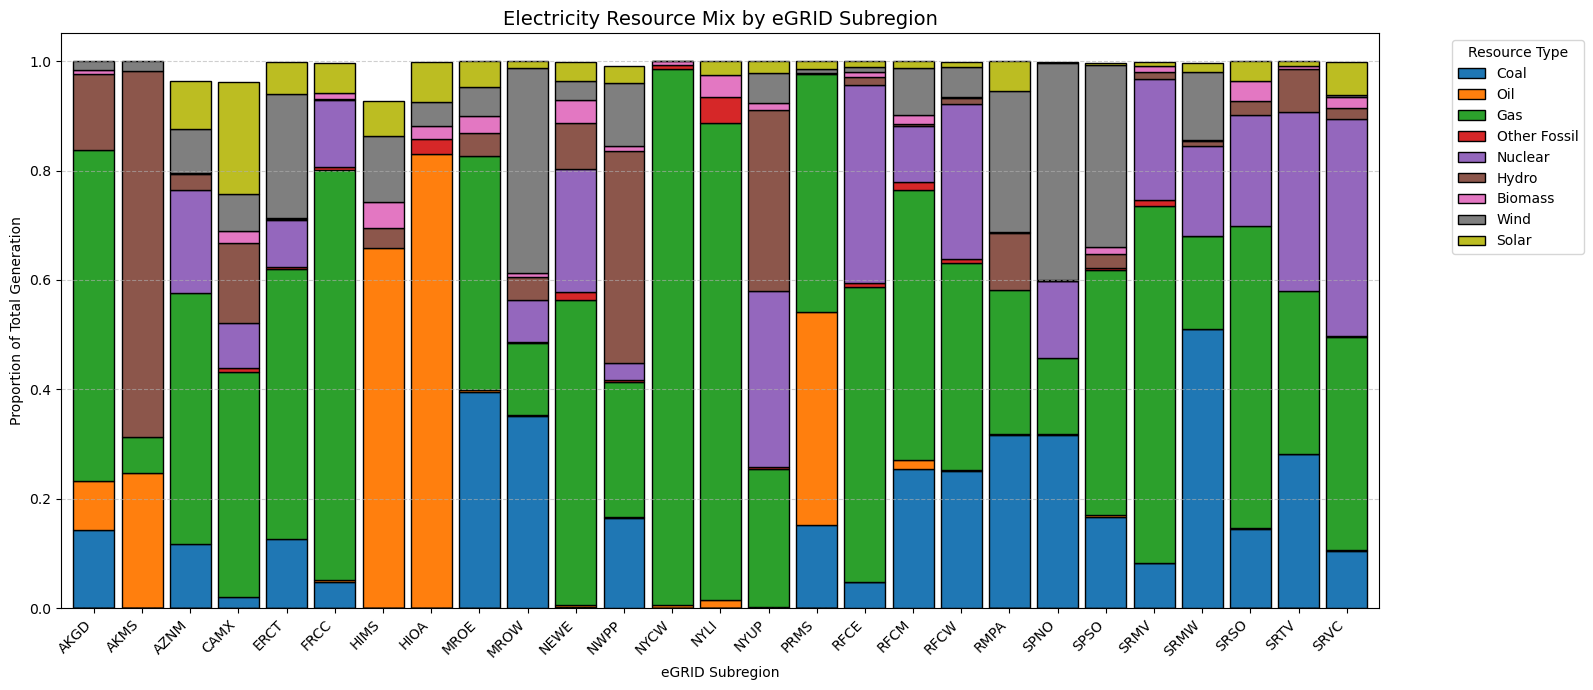

In [11]:
resource_cols = [
    "Coal", "Oil", "Gas", "Other Fossil", "Nuclear", "Hydro", 
    "Biomass", "Wind", "Solar", "Geo- thermal"
]

# Create a stacked bar chart
subregions_mix_only.set_index("eGRID subregion acronym", inplace=True)
resource_mix = subregions_mix_only[resource_cols]

# Plot
ax = resource_mix.plot(kind="bar", stacked=True, figsize=(16, 7), width=0.85, edgecolor='black')
plt.title("Electricity Resource Mix by eGRID Subregion", fontsize=14)
plt.ylabel("Proportion of Total Generation")
plt.xlabel("eGRID Subregion")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Resource Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

### Interpretation

A few trends are immediately noticeable: gas (green) dominates many subregions, particularly in the South and Midwest, indicating a strong reliance on natural gas for electricity production. Wind (gray) and solar (yellow) are prominent in certain areas like CAMX and NWPP, highlighting regions with higher renewable adoption. In contrast, subregions like HIOA and MROE have a substantial share of oil (orange) and coal (blue), respectively, indicating continued reliance on fossil fuels.

The chart also reveals considerable diversity in resource mixes—some subregions like RFCM and SRTV have a broad mix including nuclear (purple), biomass (brown), and other fossil sources (pink), while others are more concentrated. This visualization effectively highlights regional variations in energy strategy and infrastructure, making it a strong candidate for a categorical variable visualization in your EDA submission.

## eGrid Subregion 2023 Total Data

In [12]:
eGrid_total_data = pd.read_csv("subregion_total_data.csv")
eGrid_total_data = eGrid_total_data.drop(index=0).reset_index(drop=True)
eGrid_total_data

,Data Year,eGRID subregion acronym,eGRID subregion name,eGRID subregion nameplate capacity (MW),eGRID subregion annual heat input from combustion (MMBtu),eGRID subregion annual heat input from combustion (MMBtu).1,eGRID subregion total annual heat input (MMBtu),eGRID subregion total ozone season heat input (MMBtu),eGRID subregion annual net generation (MWh),eGRID subregion ozone season net generation (MWh),...,eGRID subregion nonbaseload oil generation percent (resource mix),eGRID subregion nonbaseload gas generation percent (resource mix),eGRID subregion nonbaseload nuclear generation percent (resource mix),eGRID subregion nonbaseload hydro generation percent (resource mix),eGRID subregion nonbaseload biomass generation percent (resource mix),eGRID subregion nonbaseload wind generation percent (resource mix),eGRID subregion nonbaseload solar generation percent (resource mix),eGRID subregion nonbaseload geothermal generation percent (resource mix),eGRID subregion nonbaseload other fossil generation percent (resource mix),eGRID subregion nonbaseload other unknown/ purchased fuel generation percent (resource mix)
0,2023,AKGD,ASCC Alaska Grid,2194.00,34476388.97,13324875.14,37176774.98,14366404.14,5100446.78,1975851.64,...,0.148,0.677,0.000,0.000,0.010,0.000,0.000,0.000,0.000,0.000
1,2023,AKMS,ASCC Miscellaneous,901.50,5457534.77,2242466.57,9200598.44,3746263.91,1585195.38,640259.40,...,0.792,0.208,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,2023,AZNM,WECC Southwest,54243.20,885180963.15,427921581.58,1351086055.15,629644576.57,166728432.52,81328438.84,...,0.000,0.784,0.000,0.000,0.004,0.000,0.000,0.000,0.000,0.000
3,2023,CAMX,WECC California,99264.30,818268630.18,338097573.45,1361665337.16,606941751.44,216841822.33,101987778.01,...,0.001,0.882,0.000,0.000,0.029,0.000,0.000,0.000,0.020,0.004
4,2023,ERCT,ERCOT All,145507.70,2441458265.32,1317346632.49,3328356995.84,1684152772.13,474437410.10,231953880.50,...,0.001,0.751,0.000,0.000,0.002,0.000,0.000,0.000,0.016,0.000
5,2023,FRCC,FRCC All,72773.80,1561449791.00,757431218.25,1927258108.53,921019945.61,244024971.63,120645719.13,...,0.000,0.889,0.000,0.000,0.016,0.000,0.000,0.000,0.000,0.007
6,2023,HIMS,HICC Miscellaneous,1099.20,19260745.50,7786227.09,21885690.50,9016011.09,2614533.00,1097173.64,...,0.982,0.000,0.000,0.000,0.018,0.000,0.000,0.000,0.000,0.000
7,2023,HIOA,HICC Oahu,2352.00,61965314.32,25653010.32,64586826.32,26979464.32,6547822.74,2784634.14,...,0.925,0.000,0.000,0.000,0.075,0.000,0.000,0.000,0.000,0.000
8,2023,MROE,MRO East,9637.90,215861791.51,107812267.93,227848862.52,112805923.93,24438902.71,11614418.50,...,0.018,0.417,0.000,0.000,0.027,0.000,0.000,0.000,0.000,0.000
9,2023,MROW,MRO West,77431.60,1175173096.50,567953049.11,1725979157.39,775129479.62,240962889.78,100788133.50,...,0.001,0.328,0.000,0.000,0.014,0.000,0.000,0.000,0.000,0.002


In [13]:
us_agg_data = pd.read_csv("us_agg_data.csv")
us_agg_data = us_agg_data.drop(index=0).reset_index(drop=True)
us_agg_data

,Data Year,U.S. nameplate capacity (MW),U.S. annual heat input from combustion (MMBtu),U.S. annual heat input from combustion (MMBtu).1,U.S. total annual heat input (MMBtu),U.S. total ozone season heat input (MMBtu),U.S. annual net generation (MWh),U.S. ozone season net generation (MWh),U.S. annual nonbaseload generation (MWh),U.S. annual NOx emissions (tons),...,U.S. nonbaseload oil generation percent (resource mix),U.S. nonbaseload gas generation percent (resource mix),U.S. nonbaseload nuclear generation percent (resource mix),U.S. nonbaseload hydro generation percent (resource mix),U.S. nonbaseload biomass generation percent (resource mix),U.S. nonbaseload wind generation percent (resource mix),U.S. nonbaseload solar generation percent (resource mix),U.S. nonbaseload geothermal generation percent (resource mix),U.S. nonbaseload other fossil generation percent (resource mix),U.S. nonbaseload other unknown/ purchased fuel generation percent (resource mix)
0,2023,1303568.80,21889609535.03,10513150073.76,32955527923.43,15189244757.40,4167601391.18,1898218225.61,1189184479.51,947516.58,...,0.015,0.640,0.000,0.000,0.017,0.000,0.000,0.000,0.004,0.003


## Features for Subregion Total Data

In [14]:
for col in eGrid_total_data.columns:
    print(col)

Data Year
eGRID subregion acronym
eGRID subregion name
eGRID subregion nameplate capacity (MW)
eGRID subregion annual heat input from combustion (MMBtu)
eGRID subregion annual heat input from combustion (MMBtu).1
eGRID subregion total annual heat input (MMBtu)
eGRID subregion total ozone season heat input (MMBtu)
eGRID subregion annual net generation (MWh)
eGRID subregion ozone season net generation (MWh)
eGRID subregion annual nonbaseload generation (MWh)
eGRID subregion annual NOx emissions (tons)
eGRID subregion ozone season NOx emissions (tons)
eGRID subregion annual SO2 emissions (tons)
eGRID subregion annual CO2 emissions (tons)
eGRID subregion annual CH4 emissions (lbs)
eGRID subregion annual N2O emissions (lbs)
eGRID subregion annual CO2 equivalent emissions (tons)
eGRID subregion annual Hg emissions (lbs)
eGRID subregion annual NOx total output emission rate (lb/MWh)
eGRID subregion ozone season NOx total output emission rate (lb/MWh)
eGRID subregion annual SO2 total output em

In [15]:
target = "eGRID subregion annual CO2 emissions (tons)"
exclude_gases = ["CO2", "SO2", "CH4", "N2O", "Hg", "NOx"]

columns_to_keep = [
    col for col in eGrid_total_data.columns
    if (not any(gas in col for gas in exclude_gases)) or col == target
]

eGrid_total_data = eGrid_total_data[columns_to_keep]
df_model = eGrid_total_data
df_model

,Data Year,eGRID subregion acronym,eGRID subregion name,eGRID subregion nameplate capacity (MW),eGRID subregion annual heat input from combustion (MMBtu),eGRID subregion annual heat input from combustion (MMBtu).1,eGRID subregion total annual heat input (MMBtu),eGRID subregion total ozone season heat input (MMBtu),eGRID subregion annual net generation (MWh),eGRID subregion ozone season net generation (MWh),...,eGRID subregion nonbaseload oil generation percent (resource mix),eGRID subregion nonbaseload gas generation percent (resource mix),eGRID subregion nonbaseload nuclear generation percent (resource mix),eGRID subregion nonbaseload hydro generation percent (resource mix),eGRID subregion nonbaseload biomass generation percent (resource mix),eGRID subregion nonbaseload wind generation percent (resource mix),eGRID subregion nonbaseload solar generation percent (resource mix),eGRID subregion nonbaseload geothermal generation percent (resource mix),eGRID subregion nonbaseload other fossil generation percent (resource mix),eGRID subregion nonbaseload other unknown/ purchased fuel generation percent (resource mix)
0,2023,AKGD,ASCC Alaska Grid,2194.00,34476388.97,13324875.14,37176774.98,14366404.14,5100446.78,1975851.64,...,0.148,0.677,0.000,0.000,0.010,0.000,0.000,0.000,0.000,0.000
1,2023,AKMS,ASCC Miscellaneous,901.50,5457534.77,2242466.57,9200598.44,3746263.91,1585195.38,640259.40,...,0.792,0.208,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,2023,AZNM,WECC Southwest,54243.20,885180963.15,427921581.58,1351086055.15,629644576.57,166728432.52,81328438.84,...,0.000,0.784,0.000,0.000,0.004,0.000,0.000,0.000,0.000,0.000
3,2023,CAMX,WECC California,99264.30,818268630.18,338097573.45,1361665337.16,606941751.44,216841822.33,101987778.01,...,0.001,0.882,0.000,0.000,0.029,0.000,0.000,0.000,0.020,0.004
4,2023,ERCT,ERCOT All,145507.70,2441458265.32,1317346632.49,3328356995.84,1684152772.13,474437410.10,231953880.50,...,0.001,0.751,0.000,0.000,0.002,0.000,0.000,0.000,0.016,0.000
5,2023,FRCC,FRCC All,72773.80,1561449791.00,757431218.25,1927258108.53,921019945.61,244024971.63,120645719.13,...,0.000,0.889,0.000,0.000,0.016,0.000,0.000,0.000,0.000,0.007
6,2023,HIMS,HICC Miscellaneous,1099.20,19260745.50,7786227.09,21885690.50,9016011.09,2614533.00,1097173.64,...,0.982,0.000,0.000,0.000,0.018,0.000,0.000,0.000,0.000,0.000
7,2023,HIOA,HICC Oahu,2352.00,61965314.32,25653010.32,64586826.32,26979464.32,6547822.74,2784634.14,...,0.925,0.000,0.000,0.000,0.075,0.000,0.000,0.000,0.000,0.000
8,2023,MROE,MRO East,9637.90,215861791.51,107812267.93,227848862.52,112805923.93,24438902.71,11614418.50,...,0.018,0.417,0.000,0.000,0.027,0.000,0.000,0.000,0.000,0.000
9,2023,MROW,MRO West,77431.60,1175173096.50,567953049.11,1725979157.39,775129479.62,240962889.78,100788133.50,...,0.001,0.328,0.000,0.000,0.014,0.000,0.000,0.000,0.000,0.002


In [16]:
for col in df_model.columns:
    print(col)

Data Year
eGRID subregion acronym
eGRID subregion name
eGRID subregion nameplate capacity (MW)
eGRID subregion annual heat input from combustion (MMBtu)
eGRID subregion annual heat input from combustion (MMBtu).1
eGRID subregion total annual heat input (MMBtu)
eGRID subregion total ozone season heat input (MMBtu)
eGRID subregion annual net generation (MWh)
eGRID subregion ozone season net generation (MWh)
eGRID subregion annual nonbaseload generation (MWh)
eGRID subregion annual CO2 emissions (tons)
eGRID subregion annual coal net generation (MWh)
eGRID subregion annual oil net generation (MWh)
eGRID subregion annual gas net generation (MWh)
eGRID subregion annual nuclear net generation (MWh)
eGRID subregion annual hydro net generation (MWh)
eGRID subregion annual biomass net generation (MWh)
eGRID subregion annual wind net generation (MWh)
eGRID subregion annual solar net generation (MWh)
eGRID subregion annual geothermal net generation (MWh)
eGRID subregion annual other fossil net ge

## Random Forest - Non Parametric Model

In [17]:
#Drop known non-numeric columns (like acronyms or names)
non_numeric_cols = ["eGRID subregion acronym", "eGRID subregion name"]
duplicate_col = "eGRID subregion annual heat input from combustion (MMBtu).1"

clean_data = eGrid_total_data.drop(columns=non_numeric_cols+ [duplicate_col])

#Convert remaining values to numeric
clean_data = clean_data.apply(pd.to_numeric)

# Define X and y
numeric_cols = clean_data.select_dtypes(include=[np.number]).columns.tolist()
y = clean_data[target]
X = clean_data[numeric_cols].drop(columns=[target])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(oob_score=True, random_state=42, max_features = 23) # Max_features = 1/3 of total features
model.fit(X_train, y_train)

# Predict
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

In [18]:
# OOB Score
print(f"OOB Score (R² estimate): {model.oob_score_:.4f}")

# MSE and MAE
train_mse = mean_squared_error(y_train, train_preds)
test_mse = mean_squared_error(y_test, test_preds)
train_mae = mean_absolute_error(y_train, train_preds)
test_mae = mean_absolute_error(y_test, test_preds)
r2 = r2_score(y_test, test_preds)

# Output
print(f"Training MSE: {train_mse:,.0f}")
print(f"Test MSE: {test_mse:,.0f}")
print(f"Training MAE: {train_mae:,.0f}")
print(f"Test MAE: {test_mae:,.0f}")
print(f"R² score: {r2:.4f}")

OOB Score (R² estimate): 0.7103
Training MSE: 143,856,593,445,521
Test MSE: 79,971,402,901,299
Training MAE: 6,420,664
Test MAE: 6,312,150
R² score: 0.9547


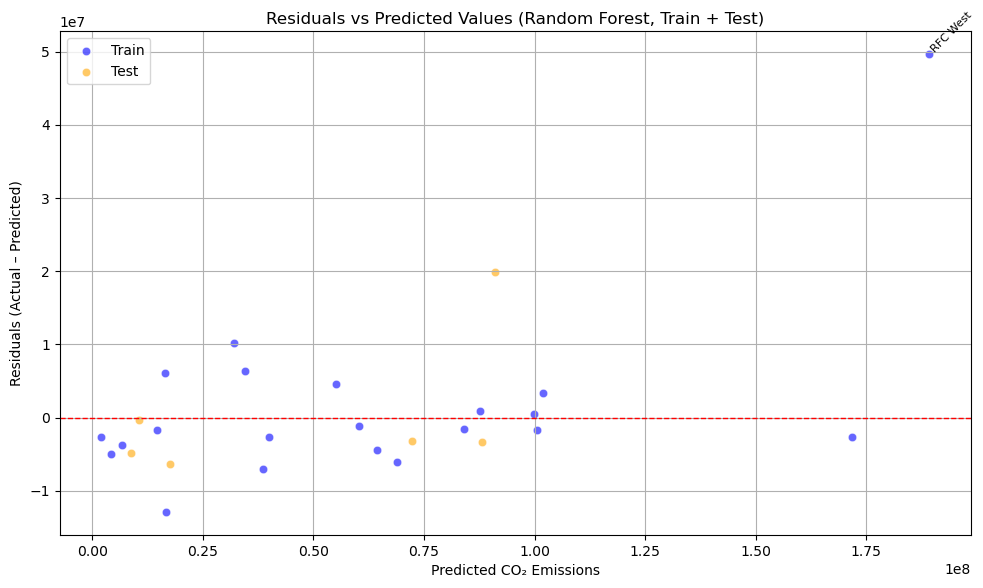

In [19]:
# Predict on the full dataset
y_all_pred = model.predict(X)

# Get subregion names
subregion_names = eGrid_total_data["eGRID subregion name"]

# Identify training vs test indices
is_train = X.index.isin(X_train.index)
is_test = X.index.isin(X_test.index)

# Calculate residuals
residuals_rf = y - y_all_pred  # Already exists
residuals_train_rf = residuals_rf[is_train]
residuals_test_rf = residuals_rf[is_test]

# Define threshold and find outliers
threshold = 3e7
outlier_indices = np.where(np.abs(residuals_rf) > threshold)[0]

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=train_preds, y=residuals_train_rf, label="Train", color="blue", alpha=0.6)
sns.scatterplot(x=test_preds, y=residuals_test_rf, label="Test", color="orange", alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=1)

# Annotate outliers
for i in outlier_indices:
    plt.text(x=y_all_pred[i], y=residuals_rf[i], s=subregion_names[i],
             fontsize=8, ha='left', va='bottom', rotation=45)

plt.xlabel("Predicted CO₂ Emissions")
plt.ylabel("Residuals (Actual – Predicted)")
plt.title("Residuals vs Predicted Values (Random Forest, Train + Test)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

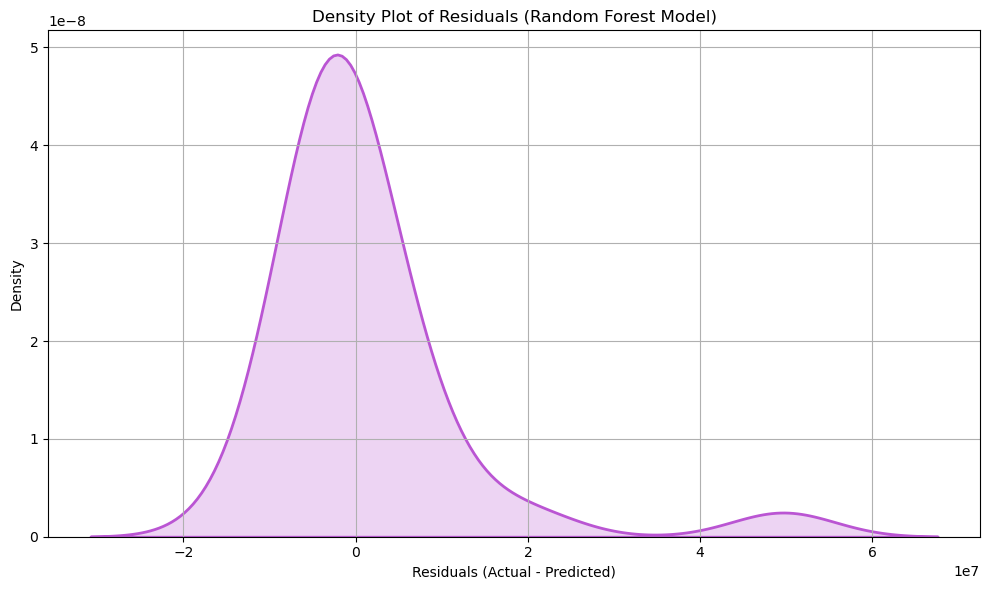

In [20]:
# Plot residuals density
plt.figure(figsize=(10, 6))
sns.kdeplot(residuals_rf, fill=True, color='mediumorchid', linewidth=2)
plt.title("Density Plot of Residuals (Random Forest Model)")
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Density")
plt.grid(True)
plt.tight_layout()
plt.show()

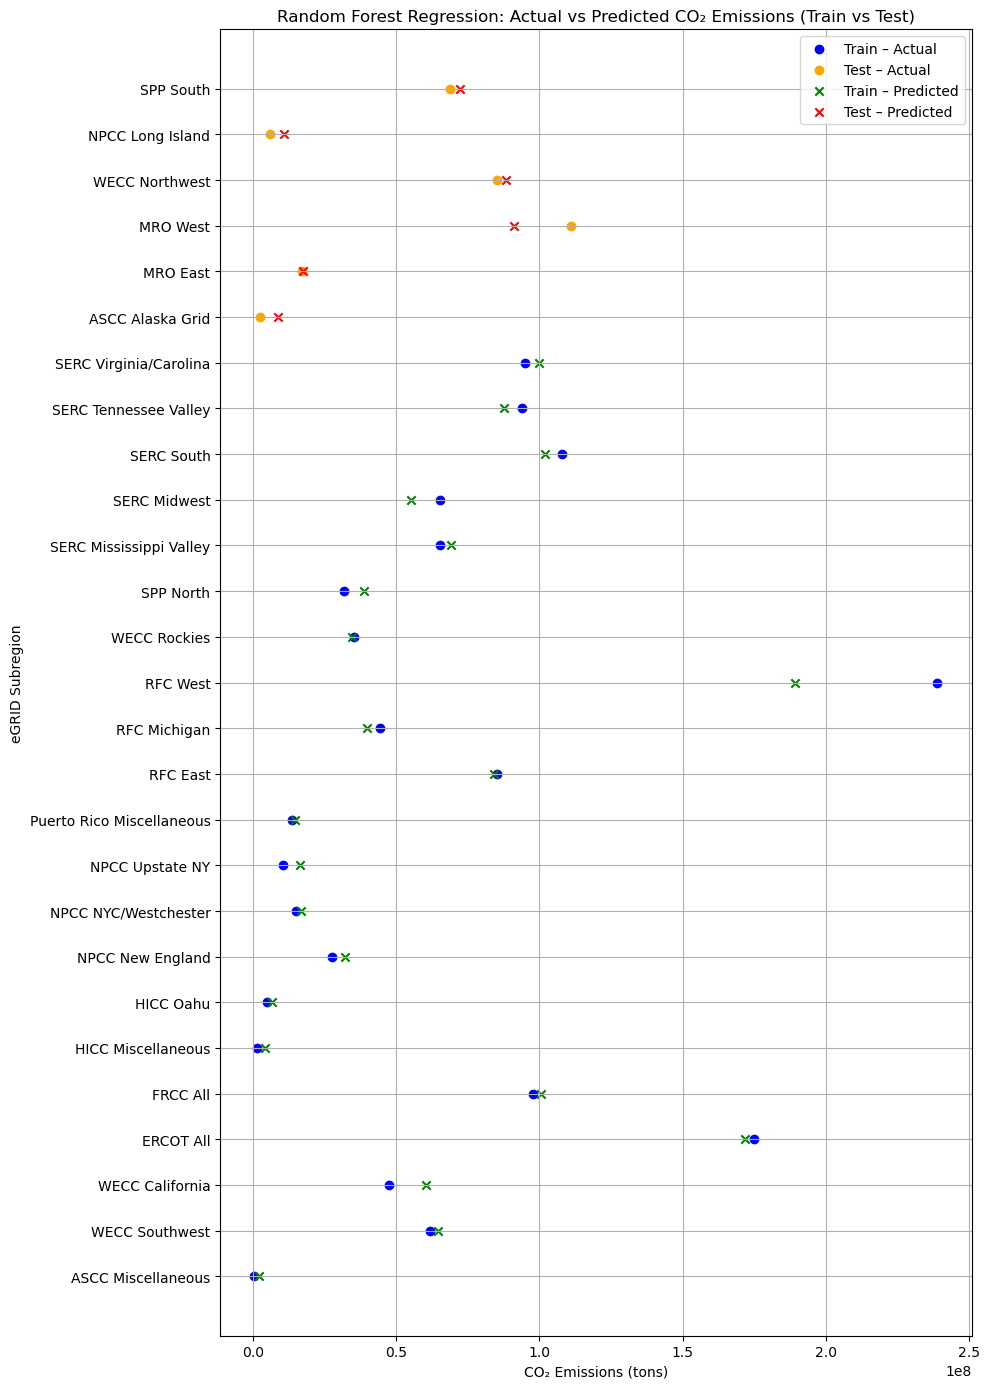

In [21]:
# Build the plot DataFrame in original order
plot_df = pd.DataFrame({
    "Subregion": subregion_names,
    "Actual_CO2": y.values,
    "Predicted_CO2": y_all_pred,
    "Set": np.where(is_train, "Train", "Test")
}, index=X.index)


plt.figure(figsize=(10, 14))

# Plot all actual values
for label, color, marker in [("Train", 'blue', 'o'), ("Test", 'orange', 'o')]:
    subset = plot_df[plot_df["Set"] == label]
    plt.scatter(subset["Actual_CO2"], subset["Subregion"], color=color, marker=marker, label=f"{label} – Actual")

# Plot all predicted values
for label, color, marker in [("Train", 'green', 'x'), ("Test", 'red', 'x')]:
    subset = plot_df[plot_df["Set"] == label]
    plt.scatter(subset["Predicted_CO2"], subset["Subregion"], color=color, marker=marker, label=f"{label} – Predicted")

plt.title("Random Forest Regression: Actual vs Predicted CO₂ Emissions (Train vs Test)")
plt.xlabel("CO₂ Emissions (tons)")
plt.ylabel("eGRID Subregion")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

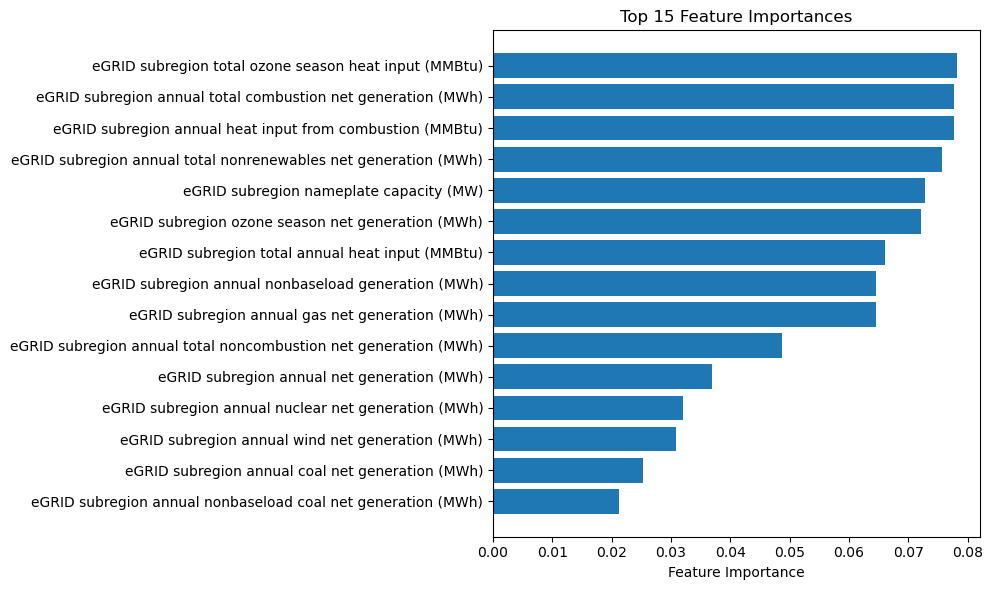

In [22]:
# Get feature importances from the trained model
importances = model.feature_importances_

# Sort and select the top 15
indices = np.argsort(importances)[-15:][::-1]
top_features = [X.columns[i] for i in indices]
top_importances = importances[indices]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_features[::-1], top_importances[::-1], align='center')
plt.xlabel("Feature Importance")
plt.title("Top 15 Feature Importances")
plt.tight_layout()
plt.show()

## Parametric Model- GLM: PCR

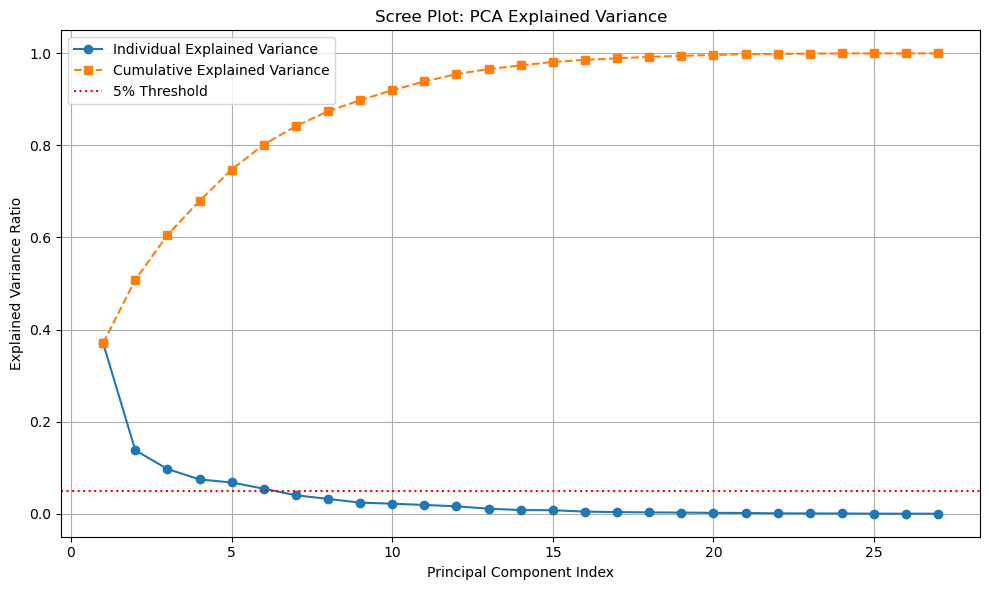

In [23]:
#Load and clean data
df = df_model.drop(columns=["eGRID subregion acronym", "eGRID subregion name"])
df = df.apply(pd.to_numeric).dropna()

#Define features (drop target column temporarily)
X = df.drop(columns=["eGRID subregion annual CO2 emissions (tons)"])
y = df["eGRID subregion annual CO2 emissions (tons)"]

#Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Scree plot
explained_var_ratio = pca.explained_variance_ratio_
cumulative_var_ratio = np.cumsum(explained_var_ratio)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_var_ratio) + 1), explained_var_ratio, marker='o', label="Individual Explained Variance")
plt.plot(range(1, len(cumulative_var_ratio) + 1), cumulative_var_ratio, marker='s', linestyle='--', label="Cumulative Explained Variance")
plt.axhline(y=0.05, color='r', linestyle=':', label="5% Threshold")
plt.xlabel("Principal Component Index")
plt.ylabel("Explained Variance Ratio")
plt.title("Scree Plot: PCA Explained Variance")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

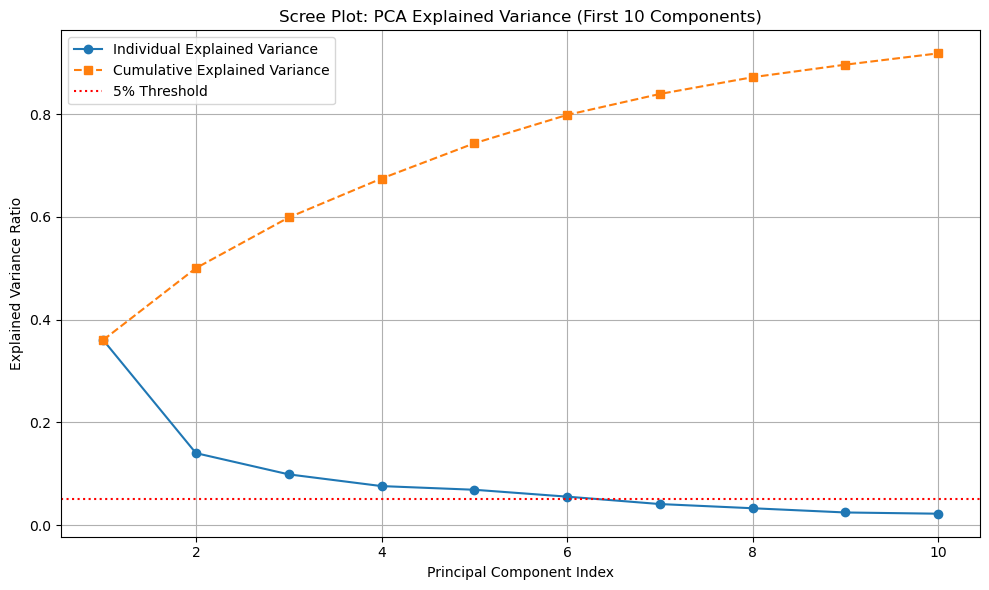

Cumulative variance explained by each component:
 [0.36037355 0.5004008  0.5990525  0.67487418 0.7435478  0.79880718
 0.83963358 0.8722885  0.89671184 0.91874026]


In [24]:
# Load and clean data
df = df_model.drop(columns=["eGRID subregion acronym", "eGRID subregion name",
                           "eGRID subregion annual heat input from combustion (MMBtu).1"])
df = df.apply(pd.to_numeric).dropna()

# Separate features and target
X = df.drop(columns=["eGRID subregion annual CO2 emissions (tons)"])
y = df["eGRID subregion annual CO2 emissions (tons)"]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA and keep 10 components
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

# Scree plot
explained_var_ratio = pca.explained_variance_ratio_
cumulative_var_ratio = np.cumsum(explained_var_ratio)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), explained_var_ratio, marker='o', label='Individual Explained Variance')
plt.plot(range(1, 11), cumulative_var_ratio, marker='s', linestyle='--', label='Cumulative Explained Variance')
plt.axhline(0.05, color='red', linestyle=':', label='5% Threshold')
plt.xlabel("Principal Component Index")
plt.ylabel("Explained Variance Ratio")
plt.title("Scree Plot: PCA Explained Variance (First 10 Components)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("Cumulative variance explained by each component:\n", cumulative_var_ratio)

In [25]:
# Check that each of the first 10 PCs is a unit vector (norm ≈ 1)
norms = np.linalg.norm(pca.components_[:10], axis=1)
print("Norms of first 10 principal components:", norms)

Norms of first 10 principal components: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [26]:
# Split the data (assumes X and y already defined)
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Add constant to training and test sets
X_train_ols = sm.add_constant(X_train)
X_test_ols = sm.add_constant(X_test)

# Fit OLS model
ols_model = sm.OLS(y_train, X_train_ols).fit()

# Print summary
print(ols_model.summary())

                                         OLS Regression Results                                        
Dep. Variable:     eGRID subregion annual CO2 emissions (tons)   R-squared:                       0.973
Model:                                                     OLS   Adj. R-squared:                  0.945
Method:                                          Least Squares   F-statistic:                     35.53
Date:                                         Mon, 12 May 2025   Prob (F-statistic):           1.77e-06
Time:                                                 22:52:39   Log-Likelihood:                -367.53
No. Observations:                                           21   AIC:                             757.1
Df Residuals:                                               10   BIC:                             768.5
Df Model:                                                   10                                         
Covariance Type:                                     nonrobust  

In [27]:
# Select the significant PCs (0-based indices: PC1, PC3, PC5)
significant_indices = [0, 2, 4]

# Subset the PCA-transformed data (X_pca) and the response variable (y)
X_pca_significant = X_pca[:, significant_indices]

# Split into training and testing sets (same split ratio and seed as before)
X_train_sig, X_test_sig, y_train_sig, y_test_sig = train_test_split(
    X_pca_significant, y, test_size=0.2, random_state=42
)

# Add intercept term for OLS
X_train_sig_ols = sm.add_constant(X_train_sig)
X_test_sig_ols = sm.add_constant(X_test_sig)

# Fit OLS model using only significant PCs
ols_model_sig = sm.OLS(y_train_sig, X_train_sig_ols).fit()

# Print OLS summary for comparison
print(ols_model_sig.summary())

                                         OLS Regression Results                                        
Dep. Variable:     eGRID subregion annual CO2 emissions (tons)   R-squared:                       0.965
Model:                                                     OLS   Adj. R-squared:                  0.959
Method:                                          Least Squares   F-statistic:                     155.3
Date:                                         Mon, 12 May 2025   Prob (F-statistic):           1.50e-12
Time:                                                 22:52:39   Log-Likelihood:                -370.17
No. Observations:                                           21   AIC:                             748.3
Df Residuals:                                               17   BIC:                             752.5
Df Model:                                                    3                                         
Covariance Type:                                     nonrobust  

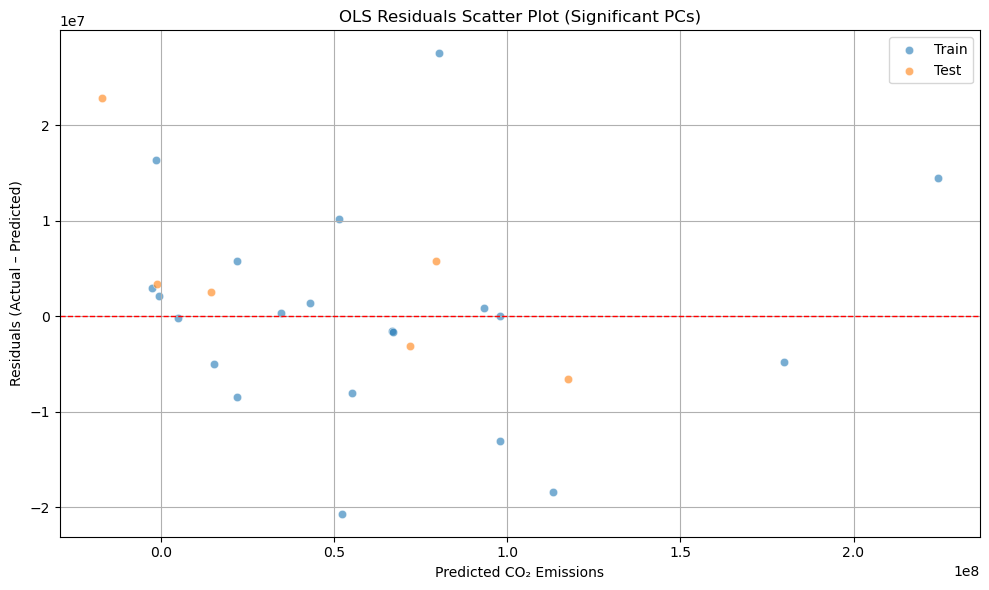

In [28]:
# Add constant to both train and test sets (for updated model)
X_train_sig_ols = sm.add_constant(X_train_sig)
X_test_sig_ols = sm.add_constant(X_test_sig)

# Get predictions
y_pred_train_sig = ols_model_sig.predict(X_train_sig_ols)
y_pred_test_sig = ols_model_sig.predict(X_test_sig_ols)

# Calculate residuals
residuals_train_sig = y_train - y_pred_train_sig
residuals_test_sig = y_test - y_pred_test_sig

# Plot residuals
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_train_sig, y=residuals_train_sig, label="Train", alpha=0.6)
sns.scatterplot(x=y_pred_test_sig, y=residuals_test_sig, label="Test", alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title("OLS Residuals Scatter Plot (Significant PCs)")
plt.xlabel("Predicted CO₂ Emissions")
plt.ylabel("Residuals (Actual – Predicted)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

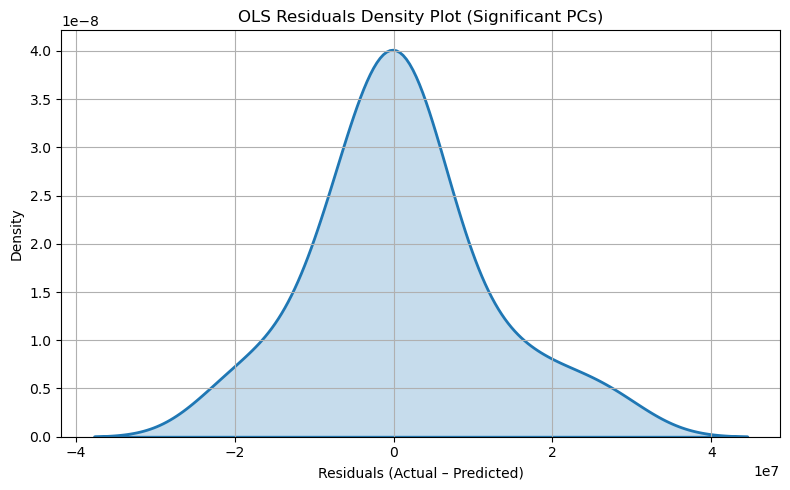

In [29]:
# Combine residuals
all_residuals_sig = np.concatenate([residuals_train_sig, residuals_test_sig])

# Plot density of residuals
plt.figure(figsize=(8, 5))
sns.kdeplot(all_residuals_sig, fill=True, linewidth=2)
plt.title("OLS Residuals Density Plot (Significant PCs)")
plt.xlabel("Residuals (Actual – Predicted)")
plt.ylabel("Density")
plt.grid(True)
plt.tight_layout()
plt.show()

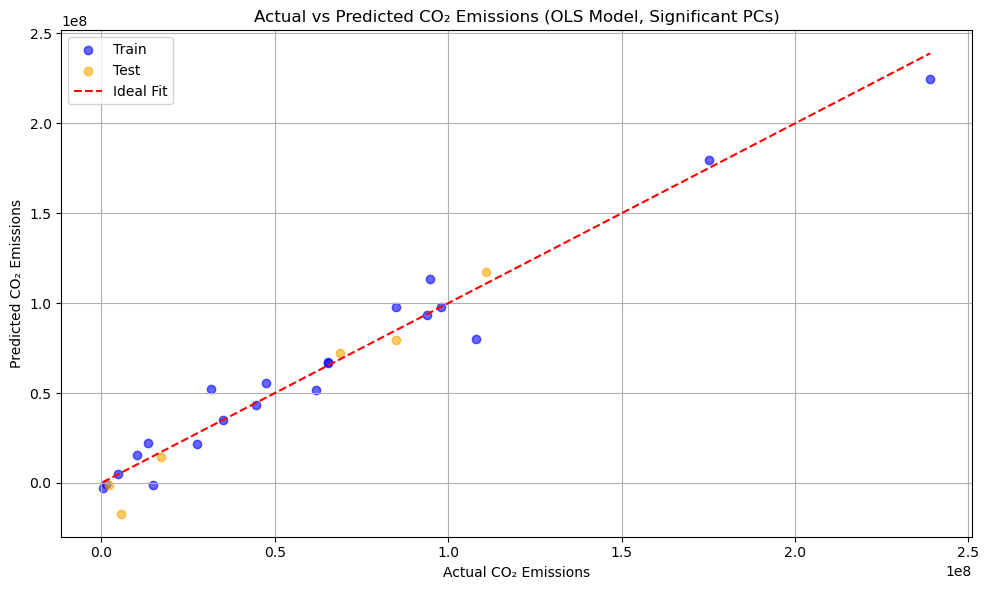

In [30]:
# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_pred_train_sig, alpha=0.6, label='Train', color='blue')
plt.scatter(y_test, y_pred_test_sig, alpha=0.6, label='Test', color='orange')

# Ideal fit line
min_val = min(y_train.min(), y_test.min())
max_val = max(y_train.max(), y_test.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal Fit')

plt.xlabel("Actual CO₂ Emissions")
plt.ylabel("Predicted CO₂ Emissions")
plt.title("Actual vs Predicted CO₂ Emissions (OLS Model, Significant PCs)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [31]:
# Convert PCA components into a readable DataFrame
loadings_df = pd.DataFrame(
    pca.components_.T,  # shape: (features, PCs)
    index=X.columns,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)]
)


for pc_index in significant_indices:
    pc_label = f'PC{pc_index + 1}'  # Convert to human-readable index
    print(f"\nTop contributing features to {pc_label}:")
    display(
        loadings_df[pc_label]
        .abs()
        .sort_values(ascending=False)
        .to_frame(name='Absolute Weight')
        .join(loadings_df[pc_label].to_frame(name='Signed Weight'))
        .head(10)
    )


Top contributing features to PC1:


,Absolute Weight,Signed Weight
eGRID subregion nameplate capacity (MW),0.222230,0.222230
eGRID subregion ozone season net generation (MWh),0.221447,0.221447
eGRID subregion annual net generation (MWh),0.220810,0.220810
eGRID subregion annual nonbaseload generation (MWh),0.218500,0.218500
eGRID subregion annual heat input from combustion (MMBtu),0.216979,0.216979
eGRID subregion annual total combustion net generation (MWh),0.216536,0.216536
eGRID subregion total ozone season heat input (MMBtu),0.216385,0.216385
eGRID subregion total annual heat input (MMBtu),0.215207,0.215207
eGRID subregion annual total nonrenewables net generation (MWh),0.210063,0.210063
eGRID subregion annual gas net generation (MWh),0.205562,0.205562



Top contributing features to PC3:


,Absolute Weight,Signed Weight
eGRID subregion coal generation percent (resource mix),0.324635,0.324635
eGRID subregion solar generation percent (resource mix),0.323292,-0.323292
eGRID subregion nonbaseload coal generation percent (resource mix),0.315951,0.315951
eGRID subregion annual solar net generation (MWh),0.275042,-0.275042
eGRID subregion annual geothermal net generation (MWh),0.257787,-0.257787
eGRID subregion nonbaseload other fossil generation percent (resource mix),0.236856,-0.236856
eGRID subregion annual coal net generation (MWh),0.235248,0.235248
eGRID subregion biomass generation percent (resource mix),0.223998,-0.223998
eGRID subregion nonbaseload biomass generation percent (resource mix),0.221276,-0.221276
eGRID subregion annual nonbaseload coal net generation (MWh),0.214598,0.214598



Top contributing features to PC5:


,Absolute Weight,Signed Weight
eGRID subregion oil generation percent (resource mix),0.364708,0.364708
eGRID subregion nonbaseload oil generation percent (resource mix),0.337669,0.337669
eGRID subregion annual oil net generation (MWh),0.332095,0.332095
eGRID subregion annual nonbaseload oil net generation (MWh),0.331391,0.331391
eGRID subregion nonbaseload gas generation percent (resource mix),0.323341,-0.323341
eGRID subregion gas generation percent (resource mix),0.259340,-0.259340
eGRID subregion other unknown/ purchased fuel generation percent (resource mix),0.218856,-0.218856
eGRID subregion total nonrenewables other unknown/purchased generation percent (resource mix),0.218856,-0.218856
eGRID subregion geothermal generation percent (resource mix),0.153058,0.153058
eGRID subregion annual nonbaseload coal net generation (MWh),0.139578,0.139578


In [32]:
# Drop the intercept (the first value in .params)
ols_coefs = ols_model.params[1:]

# Get only the coefficients for significant PCs
significant_coefs = ols_coefs.iloc[significant_indices]

# Loadings already created earlier from pca.components_.T
significant_pcs = [f'PC{i+1}' for i in significant_indices]
significant_loadings_df = loadings_df[significant_pcs]

# Perform matrix multiplication to get back-projected feature importance
# Shape: (features x PCs) • (PCs x 1) = (features x 1)
back_projected_importance = significant_loadings_df.values @ significant_coefs.values

back_projected_df = pd.DataFrame({
    'feature': X.columns,
    'importance': back_projected_importance
}).sort_values(by='importance', ascending=False)

# Show top features
print("Top contributing original features (based on significant PCs only):")
display(back_projected_df.head(10))

Top contributing original features (based on significant PCs only):


,feature,importance
44,eGRID subregion annual nonbaseload coal net ge...,4.143268e+06
8,eGRID subregion annual coal net generation (MWh),4.084280e+06
3,eGRID subregion total annual heat input (MMBtu),3.408666e+06
4,eGRID subregion total ozone season heat input ...,3.382093e+06
2,eGRID subregion annual heat input from combust...,3.376109e+06
19,eGRID subregion annual total nonrenewables net...,3.329190e+06
5,eGRID subregion annual net generation (MWh),3.198191e+06
23,eGRID subregion annual total combustion net ge...,3.195002e+06
6,eGRID subregion ozone season net generation (MWh),3.079354e+06
11,eGRID subregion annual nuclear net generation ...,2.968595e+06


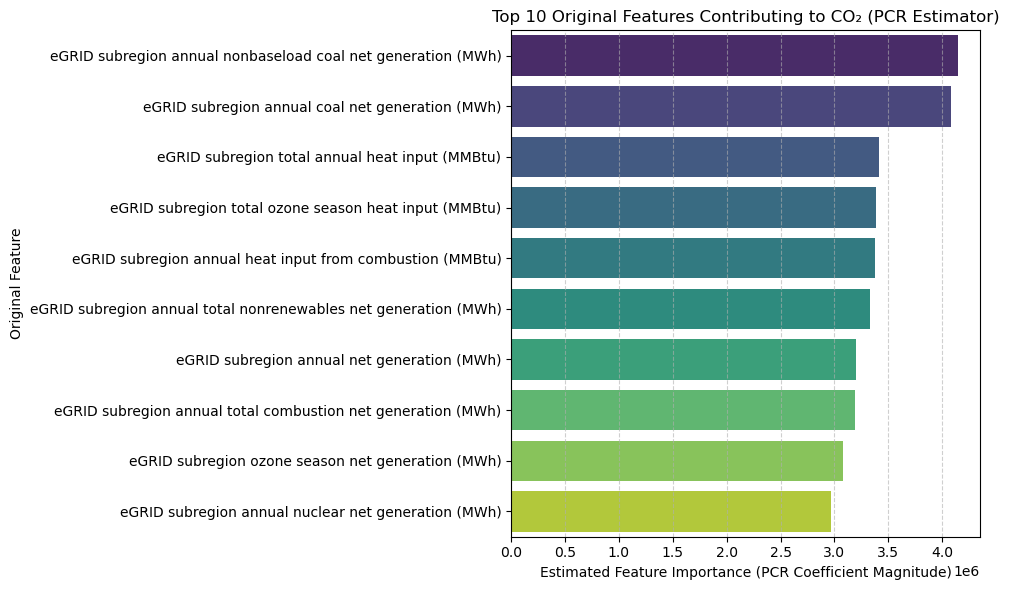

In [33]:
# Get the top 10 features (already sorted in importance_df)
top_features_df = back_projected_df.head(10)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    y='feature',
    x='importance',
    hue='feature',
    data=top_features_df,
    dodge=False,
    palette='viridis',
    legend=False  # turn off legend to keep it clean
)


# Labels and title
plt.xlabel("Estimated Feature Importance (PCR Coefficient Magnitude)")
plt.ylabel("Original Feature")
plt.title("Top 10 Original Features Contributing to CO₂ (PCR Estimator)")
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()